<a href="https://colab.research.google.com/github/NguyenVanTrong21130581/ProjectDM/blob/main/Cardiomegaly_Disease_Classifier_RF_SVM_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_data_path = '/content/drive/MyDrive/Colab Notebooks/Cardiomegaly_Test/Train'
test_data_path = '/content/drive/MyDrive/Colab Notebooks/Cardiomegaly_Test/Test'
#/content/drive/MyDrive/Colab Notebooks/Cardiomegaly_Dataset/train
#/content/drive/MyDrive/Colab Notebooks/Cardiomegaly_Dataset/test

In [5]:
import os
import pandas as pd

def create_dataframe(data_path):
    filepaths = []
    labels = []

    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        filelists = os.listdir(f_path)
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    return pd.concat([Fseries, Lseries], axis=1)

train_df = create_dataframe(train_data_path)
test_df = create_dataframe(test_data_path)

In [6]:
from sklearn.model_selection import train_test_split
valid,test = train_test_split(test_df,train_size= 0.5,shuffle=True,random_state=45)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 128, 128
img_size = (224, 224)
batch_size = 8

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

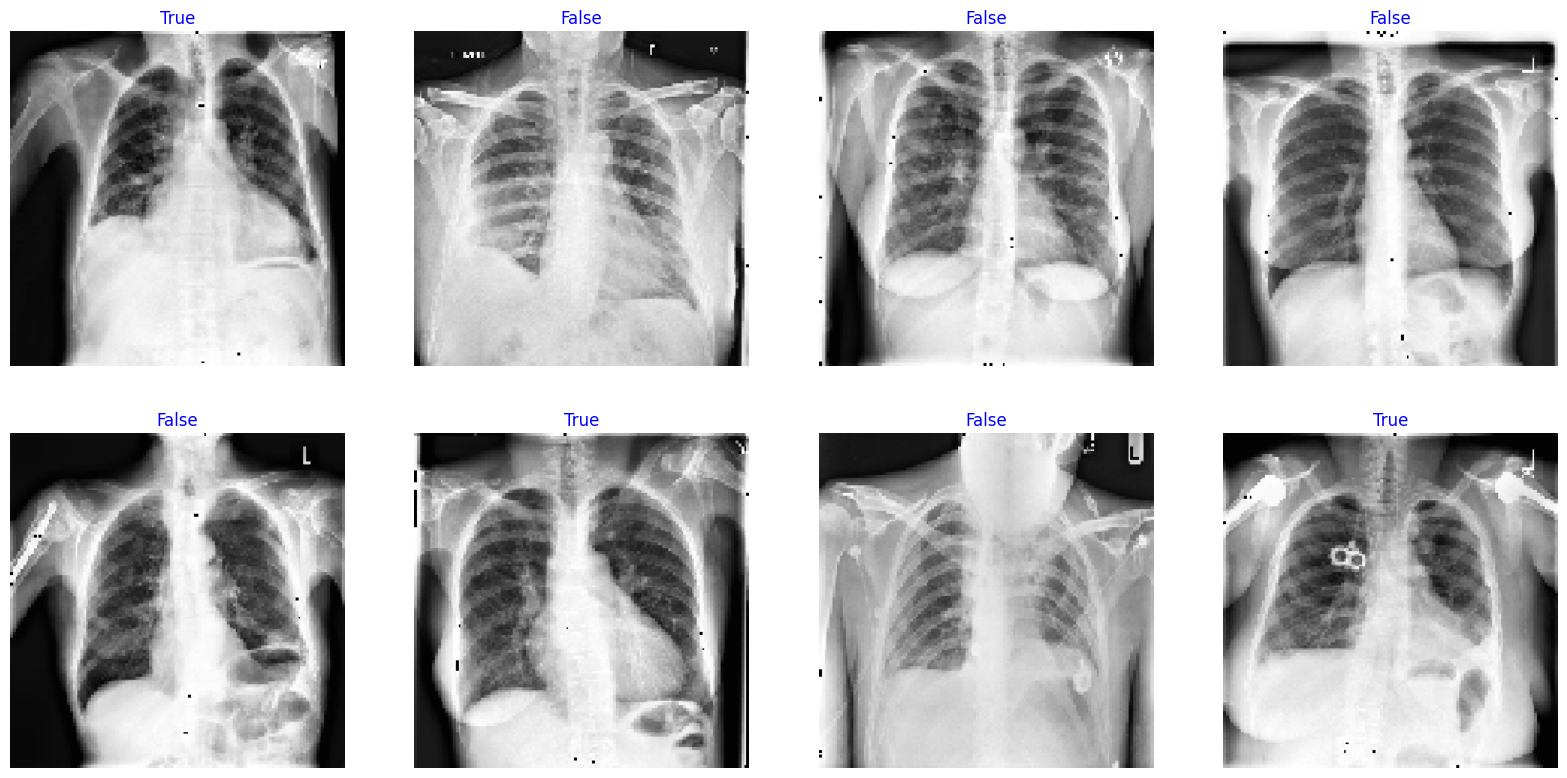

In [8]:
import matplotlib.pyplot as plt
import numpy as np

gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

RANDOMFOREST

In [ ]:
import cv2
from sklearn.preprocessing import StandardScaler
# Hàm trích xuất đặc trưng từ ảnh
def extract_features(df, img_size=(224, 224)):
    features = []
    labels = []

    for idx, row in df.iterrows():
        img = cv2.imread(row['filepaths'])
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_flatten = img.flatten()
        features.append(img_flatten)
        labels.append(row['label'])

    return np.array(features), np.array(labels)

# Trích xuất đặc trưng
X_train, y_train = extract_features(train_df)
X_test, y_test = extract_features(test_df)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Chuyển nhãn sang dạng số
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import numpy as np

# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# Đánh giá bằng Cross-Validation (CV)
rf_scores = cross_val_score(rf_model, X_train_scaled, y_train_encoded, cv=5, scoring='accuracy')
print(f"Random Forest CV Accuracy: {np.mean(rf_scores):.4f} (±{np.std(rf_scores):.4f})")

# Huấn luyện mô hình trên toàn bộ tập train
rf_model.fit(X_train_scaled, y_train_encoded)

# Đánh giá trên tập test
y_pred_rf = rf_model.predict(X_test_scaled)
rf_test_acc = rf_model.score(X_test_scaled, y_test_encoded)
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")

# In classification report (precision, recall, f1-score)
print("Classification Report for Random Forest:")
print(classification_report(y_test_encoded, y_pred_rf))

Random Forest CV Accuracy: 0.6949 (±0.0876)
Random Forest Test Accuracy: 0.6111
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.61      0.62      0.61       108
           1       0.61      0.60      0.61       108

    accuracy                           0.61       216
   macro avg       0.61      0.61      0.61       216
weighted avg       0.61      0.61      0.61       216



In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Khởi tạo mô hình SVM với kernel tuyến tính
svm_model = SVC(kernel='linear', probability=True)

# Huấn luyện mô hình
svm_model.fit(X_train_scaled, y_train_encoded)

# Dự đoán trên tập test
y_pred_svm = svm_model.predict(X_test_scaled)

# Accuracy
svm_test_acc = svm_model.score(X_test_scaled, y_test_encoded)
print(f"SVM Test Accuracy: {svm_test_acc:.4f}")

# Báo cáo phân loại
print("Classification Report for SVM:")
print(classification_report(y_test_encoded, y_pred_svm))

SVM Test Accuracy: 0.5787
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       108
           1       0.57      0.61      0.59       108

    accuracy                           0.58       216
   macro avg       0.58      0.58      0.58       216
weighted avg       0.58      0.58      0.58       216



In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Khởi tạo mô hình KNN
knn_model = KNeighborsClassifier(n_neighbors=5)

# Huấn luyện mô hình
knn_model.fit(X_train_scaled, y_train_encoded)

# Dự đoán trên tập test
y_pred_knn = knn_model.predict(X_test_scaled)

# Accuracy
knn_test_acc = knn_model.score(X_test_scaled, y_test_encoded)
print(f"KNN Test Accuracy: {knn_test_acc:.4f}")

# Báo cáo phân loại
print("Classification Report for KNN:")
print(classification_report(y_test_encoded, y_pred_knn))

KNN Test Accuracy: 0.5741
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55       108
           1       0.57      0.62      0.59       108

    accuracy                           0.57       216
   macro avg       0.57      0.57      0.57       216
weighted avg       0.57      0.57      0.57       216

